### ДЗ 5. Урок 5. Случайный лес

### -- Автор: Шенк Евгений Станиславович

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### Задание 5.1.

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

### Выполнено: реализованы критерии останова по количеству листьев и глубине дерева.

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=100,n_features = 2, 
                                                                          n_informative = 2, n_classes = 2,
                                                                          n_redundant=0, n_clusters_per_class=1,
                                                                          random_state=2177)

In [3]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3, 
                                                                                     random_state=1)

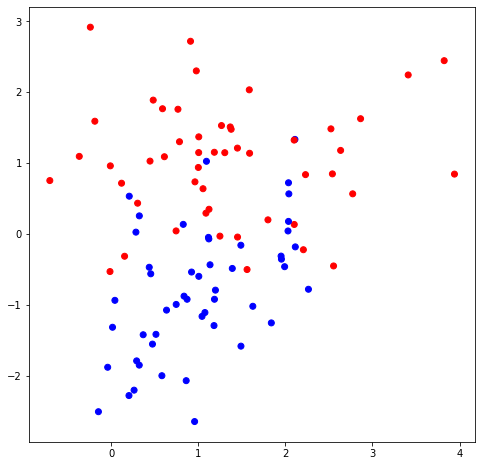

In [4]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

### Дерево

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction      

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    # min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=5, max_leaves=20, tree_depth=20):

    quality, t, index = find_best_split(data, labels, min_leaf)

    #  1. Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #  2. прекращаем рекурсию, когда достигнута максимальная глубина дерева
    #  3. прекращаем рекурсию, когда достигнуто максимальное количество листьев 
    #  (количество листьев считаем по кол-ву Нодов + 1)    
    if quality == 0 or tree_depth == 0 or max_leaves <= 1:
        max_leaves += 1
        return Leaf(data, labels), max_leaves

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    max_leaves -= 2
    
    # Рекурсивно строим два поддерева
    true_branch, max_leaves = build_tree(true_data, true_labels, min_leaf, max_leaves, tree_depth = tree_depth - 1)
    false_branch, max_leaves = build_tree(false_data, false_labels, min_leaf, max_leaves, tree_depth = tree_depth - 1)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), max_leaves

### Случайный лес

In [16]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    index = []
    oob = []  # Объекты не попавшие в выборку
    
    for i in range(N):
        index = []
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        oob_data = []
        oob_labels = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            index.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
        for x in range(n_samples):
            if x not in index:
                oob_data.append(data[x])
                oob_labels.append(labels[x])
        oob.append((oob_data, oob_labels))
        
    return bootstrap, oob

In [17]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, oob_data = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels)[0])
        
    return forest, oob_data

In [18]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

## Лес из 1 дерева

In [19]:
n_trees = 1
my_forest, oob = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 80.000
Точность случайного леса из 1 деревьев на тестовой выборке: 80.000


Text(0.5, 1.0, 'Test accuracy=80.00')

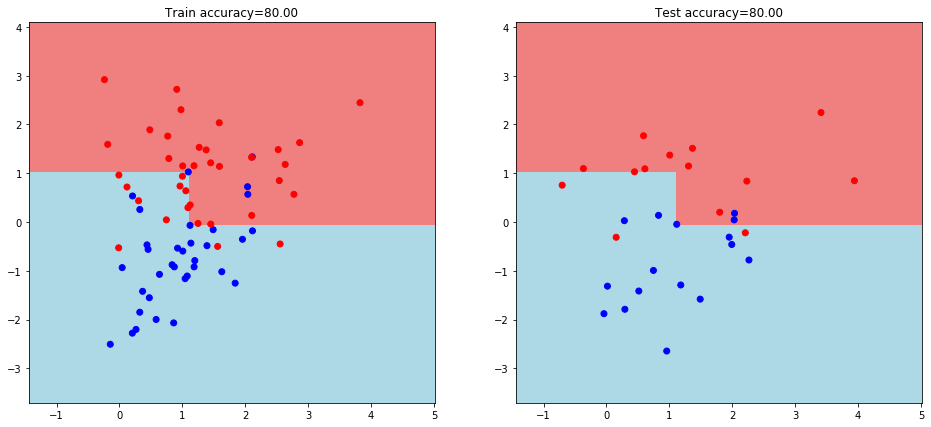

In [20]:
# Визуализируем лес на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
# mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Лес из 3 деревьев

In [21]:
n_trees = 3
my_forest, oob = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 82.857
Точность случайного леса из 3 деревьев на тестовой выборке: 76.667


Text(0.5, 1.0, 'Test accuracy=76.67')

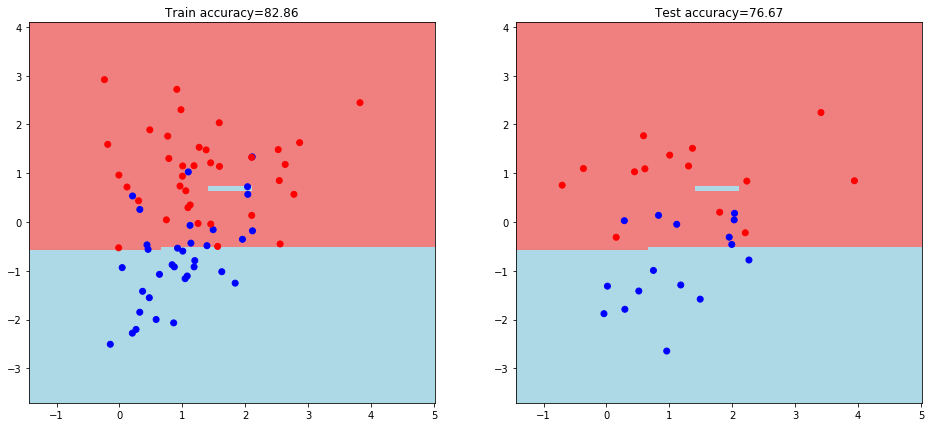

In [22]:
# Визуализируем лес на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
# mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Лес из 10 деревьев

In [23]:
n_trees = 10
my_forest, oob = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 88.571
Точность случайного леса из 10 деревьев на тестовой выборке: 83.333


Text(0.5, 1.0, 'Test accuracy=83.33')

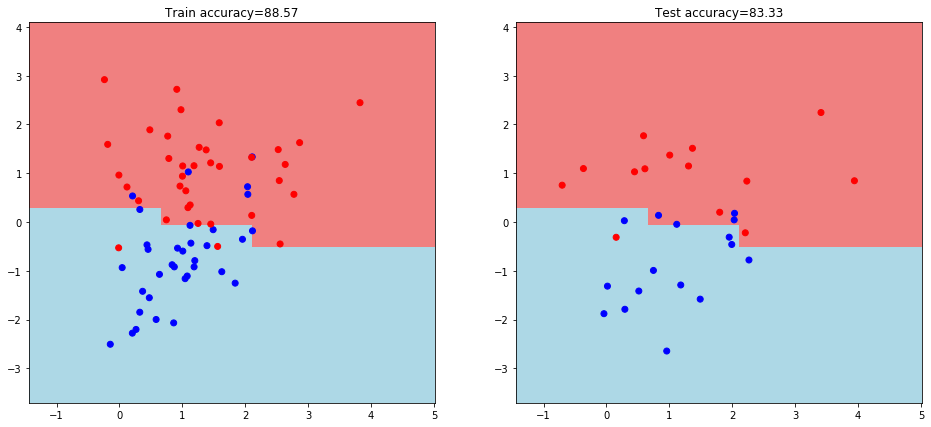

In [24]:
# Визуализируем лес на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
# mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Лес из 50 деревьев

In [25]:
n_trees = 50
my_forest, oob = random_forest(train_data, train_labels, n_trees)
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 87.143
Точность случайного леса из 50 деревьев на тестовой выборке: 76.667


Text(0.5, 1.0, 'Test accuracy=76.67')

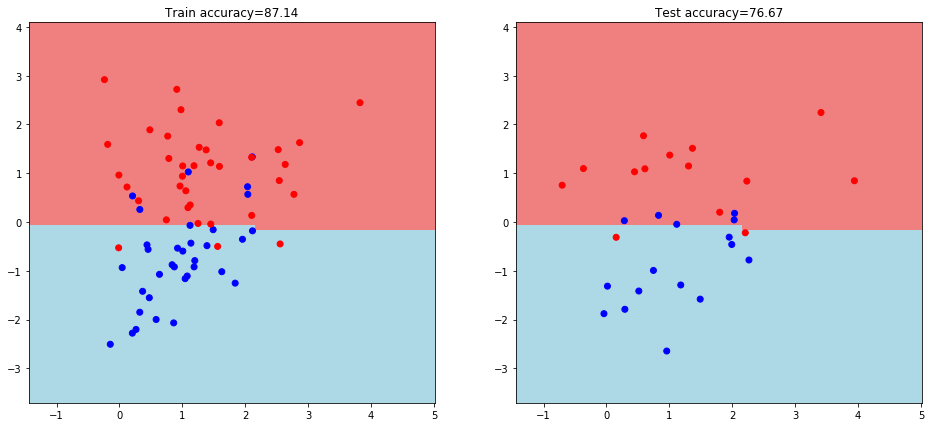

In [26]:
# Визуализируем лес на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
# mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Выводы:

При разных выборках(разный random_state при генерации данных) из 100 объектов сложность получаемой гиперплоскости увеличивалась при количестве деревьев 1 - 3 - 10, но при 50 деревьях иногда похож на прямую (в некоторых случаях ухудшался результат (Test accuracy))
Получается, что при 1 дереве модель чаше всего недообучена
при 3 или 10 результат лучше чем при 1 дереве, иногда получался лучший результат
при 50 модель переобучается, результат получается иногда лучше предыдущих иногда хуже.

### Задание 5.2.

2*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [27]:
# Введем функцию подсчета точности как доли правильных ответов на данных не вошедших в bootstrap выборки
def oob_metric(data, my_forest, oob_data):
    result =[]
    # Делаем предсказание на каждом дереве на данных не вошедших в bootstrap выборку
    for i in range(len(my_forest)):
        oob_answers = predict(oob_data[i][0], my_forest[i])
      
        # Для каждого дерева считаем accuracy по OOB выборке и добавляем в result
        correct = 0
        for j in range(len(oob_data[i][1])):
            if oob_answers[j] == oob_data[i][1][j]:
                correct += 1
        result.append(correct / float(len(oob_data[i][1])) * 100.0)
    
    # Получаем среднее значение accuracy по всем деревьям на данных не вошедших в bootstrap выборки
    return np.mean(result)

In [28]:
n_trees = 1
my_forest, oob_data = random_forest(classification_data, classification_labels, n_trees)

oob_metric(classification_data, my_forest, oob_data)

81.81818181818183

In [29]:
n_trees = 3
my_forest, oob_data = random_forest(classification_data, classification_labels, n_trees)

oob_metric(classification_data, my_forest, oob_data)

70.8407605466429

In [30]:
n_trees = 10
my_forest, oob_data = random_forest(classification_data, classification_labels, n_trees)

oob_metric(classification_data, my_forest, oob_data)

78.07881602257922

In [31]:
n_trees = 50
my_forest, oob_data = random_forest(classification_data, classification_labels, n_trees)

oob_metric(classification_data, my_forest, oob_data)

77.95972444073632

### Задание 5.3.

 3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [32]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [33]:
# Расчет критерия энтропии Шеннона

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [34]:
# Расчет качества

def quality(left_labels, right_labels, current_criteria, method='gini'):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if method == 'gini':
        return current_criteria - p * gini(left_labels) - (1 - p) * gini(right_labels)
    if method == 'entropy':
        return current_criteria - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

In [35]:
labels_1 = np.array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1])
labels_true_1 = np.array([1, 1, 1, 1, 1, 1])
labels_false_1 = np.array([0, 0, 0, 0])

In [36]:
quality(labels_true_1, labels_false_1, gini(labels_1), method='gini')

0.48

In [37]:
quality(labels_true_1, labels_false_1, calc_entropy(labels_1), method='entropy')

0.9709505944546686

In [38]:
labels_2 = np.array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1])
labels_true_2 = np.array([1, 1, 0, 1, 1])
labels_false_2 = np.array([0, 0, 1, 0, 1])

In [39]:
quality(labels_true_2, labels_false_2, gini(labels_2), method='gini')

0.08000000000000007

In [40]:
quality(labels_true_2, labels_false_2, calc_entropy(labels_2), method='entropy')

0.12451124978365313